In [7]:
# Import libraries
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [8]:
# Function to compute GLCM
def compute_glcm(image, distance=1, angle=0):
    rows, cols = image.shape
    max_gray = 256
    glcm = np.zeros((max_gray, max_gray), dtype=np.uint32)

    dx = int(np.round(np.cos(angle) * distance))
    dy = int(np.round(np.sin(angle) * distance))

    for y in range(rows):
        for x in range(cols):
            if (0 <= x + dx < cols) and (0 <= y + dy < rows):
                i = image[y, x]
                j = image[y + dy, x + dx]
                glcm[i, j] += 1

    glcm = glcm + glcm.T  # Symmetric
    glcm = glcm / np.sum(glcm)  # Normalize
    return glcm

# Function to compute features from GLCM
def compute_features(glcm):
    contrast = 0
    homogeneity = 0
    energy = 0
    correlation = 0

    mean_i = np.sum(np.arange(256) * np.sum(glcm, axis=1))
    mean_j = np.sum(np.arange(256) * np.sum(glcm, axis=0))
    std_i = np.sqrt(np.sum((np.arange(256) - mean_i)**2 * np.sum(glcm, axis=1)))
    std_j = np.sqrt(np.sum((np.arange(256) - mean_j)**2 * np.sum(glcm, axis=0)))

    for i in range(256):
        for j in range(256):
            contrast += (i - j) ** 2 * glcm[i, j]
            homogeneity += glcm[i, j] / (1.0 + abs(i - j))
            energy += glcm[i, j] ** 2
            if std_i > 0 and std_j > 0:
                correlation += (i * j * glcm[i, j] - mean_i * mean_j) / (std_i * std_j)

    return [contrast, homogeneity, energy, correlation]


In [9]:
# Define your dataset path
dataset_path = 'datasets/'

# Prepare data
X = []
y = []

labels = os.listdir(dataset_path)

for label in labels:
    class_folder = os.path.join(dataset_path, label)
    if os.path.isdir(class_folder):
        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path)
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = cv2.resize(gray, (256, 256))  # Resize if needed

                glcm = compute_glcm(gray)
                features = compute_features(glcm)

                X.append(features)
                y.append(label)

print(f"Total samples: {len(X)}")


Total samples: 3000


In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6533333333333333

Confusion Matrix:
 [[168 145]
 [ 63 224]]

Classification Report:
               precision    recall  f1-score   support

          no       0.73      0.54      0.62       313
         yes       0.61      0.78      0.68       287

    accuracy                           0.65       600
   macro avg       0.67      0.66      0.65       600
weighted avg       0.67      0.65      0.65       600



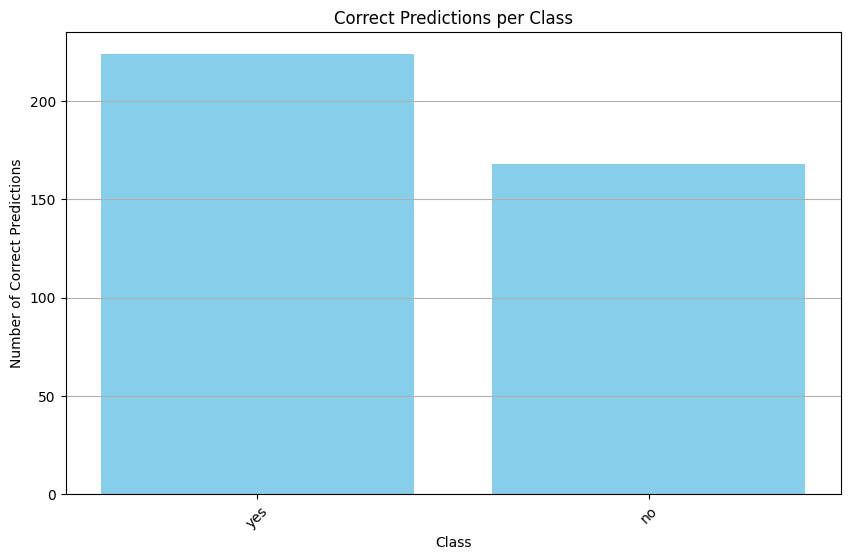

In [11]:
# Get the unique class labels
classes = list(set(y_test))

# Create a dictionary to store correct predictions
correct_preds = {label: 0 for label in classes}

# Count correct predictions per class
for true_label, pred_label in zip(y_test, y_pred):
    if true_label == pred_label:
        correct_preds[true_label] += 1

# Plotting
plt.figure(figsize=(10,6))
plt.bar(correct_preds.keys(), correct_preds.values(), color='skyblue')
plt.title("Correct Predictions per Class")
plt.xlabel("Class")
plt.ylabel("Number of Correct Predictions")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
